In [102]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from polygon import SoftPolygon, RasLoss
from cotracker import Cotracker, DAVIS_Video, CoEvaler, VideoLoss
import os
import logging
from Loader_17 import DAVIS_Rawset, np, reserve_color, normalize
from deform_video import DAVIS_withPoint
import json
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import random
from preprocess_utensils import get_boundary_points, uniform_sample_points
from einops import repeat
from deform_model import (
    DeformableTransformerDecoderLayer,
    DeformableTransformerDecoder,
    get_batch_average_bou_iou,
    add_mid_points,
)
from tqdm import tqdm

In [23]:
class DAVIS_Aug_Rawset:
    def __init__(self, is_train=True) -> None:
        if is_train:
            data_type = "train"
        else:
            data_type = "val"
        data_path = f"./2017/{data_type}_video_datas.json"
        video_datas = json.load(open(data_path, "r"))
        self.data_set = []
        img_transforms = transforms.Compose([])
        anno_transform = transforms.Compose([])
        for video_name, video_data in video_datas.items():
            img_paths = video_data["img_paths"]
            anno_paths = video_data["anno_paths"]
            anno_colors = video_data["anno_colors"]
            for anno_color in anno_colors:
                self.data_set.append([])
                for img_path, anno_path in zip(img_paths, anno_paths):
                    img_tensor = img_transforms(Image.open(img_path).convert("RGB"))
                    anno_img = Image.open(anno_path).convert("RGB")
                    anno_array = np.array(anno_img)
                    anno_mask = reserve_color(anno_array, anno_color)
                    anno_tensor = anno_transform(Image.fromarray(anno_mask))
                    # anno_tensor = anno_tensor.squeeze(0)
                    # print(np.array(anno_tensor).shape)
                    self.data_set[-1].append((img_tensor, anno_tensor))

    def get_item(self, video_idx, frame_idx):
        return self.data_set[video_idx][frame_idx]

In [107]:
val_origin_set = DAVIS_Rawset(is_train=False)
val_point_set = DAVIS_withPoint(val_origin_set, 32, is_train=False)

In [24]:
val_raw_set = DAVIS_Aug_Rawset(is_train=False)

In [63]:
train_raw_set = DAVIS_Aug_Rawset(is_train=True)

<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


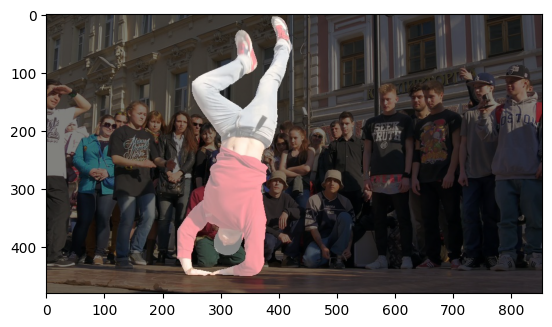

In [30]:
img, mask = val_raw_set.data_set[5][0]
print(type(img), type(mask))
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.show()

In [103]:
def _get_boundary_points(mask: torch.Tensor, point_num: int) -> torch.Tensor:
            boundary = get_boundary_points(mask.numpy().astype(np.uint8))
            boundary = uniform_sample_points(boundary, point_num)
            boundary = torch.tensor(boundary, dtype=torch.float32)
            return boundary

In [ ]:
class DAVIS_Aug_Dataset(Dataset):
    def __init__(
        self,
        raw_set: list,
        point_num: int,
        frame_num: int,
        is_eval: bool,
    ) -> None:
        super().__init__()
        # remove all the video with empty frame
        empty_video_idxs = []
        for video_idx, video_data in enumerate(raw_set):
            for frame_data in video_data:
                img, mask = frame_data
                mask = np.array(mask)
                if mask.sum() == 0:
                    empty_video_idxs.append(video_idx)
                    break
        self.data = []
        for video_idx, video_data in enumerate(raw_set):
            if video_idx in empty_video_idxs:
                continue
            self.data.append(video_data)
        self.point_num = point_num
        self.frame_num = frame_num
        self.is_eval = is_eval
        im_mean = (124, 116, 104)
        self.flip = transforms.RandomHorizontalFlip()
        self.img_transforms = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    (224, 224),
                    scale=(0.36, 1.00),
                    interpolation=InterpolationMode.BICUBIC,
                ),
                transforms.RandomAffine(
                    degrees=15,
                    shear=10,
                    interpolation=InterpolationMode.BICUBIC,
                    fill=im_mean,
                ),
                transforms.ColorJitter(0.1, 0.03, 0.03, 0),
                transforms.RandomGrayscale(0.05),
                transforms.ColorJitter(0.01, 0.01, 0.01, 0),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.anno_transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    (224, 224),
                    scale=(0.36, 1.00),
                    interpolation=InterpolationMode.NEAREST,
                ),
                transforms.RandomAffine(
                    degrees=15,
                    shear=10,
                    interpolation=InterpolationMode.NEAREST,
                    fill=0,
                ),
                transforms.ToTensor(),
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_data = self.data[idx]
        total_frame_num = len(video_data)
        selected_frame_idxs = []
        if total_frame_num <= self.frame_num:
            selected_frame_idxs = list(range(total_frame_num))
        else:
            selected_frame_idxs.append(0)
            interval = (total_frame_num - 1) // (self.frame_num - 1)
            if self.is_eval:
                offset = 0
            else:
                offset_min = -(interval - 1)
                offset_max = (total_frame_num - 1) - (self.frame_num - 1) * interval
                offset = random.randint(offset_min, offset_max)
            for i in range(1, self.frame_num):
                selected_frame_idxs.append(i * interval + offset)
        img_list = []
        mask_list = []

        def reseed(seed):
            random.seed(seed)
            torch.manual_seed(seed)

        flip_seed = np.random.randint(2147483647)
        for frame_idx in selected_frame_idxs:
            raw_img, raw_mask = video_data[frame_idx]
            sequence_seed = np.random.randint(2147483647)
            reseed(flip_seed)
            img = self.flip(raw_img)
            reseed(sequence_seed)
            img = self.img_transforms(img)
            reseed(flip_seed)
            mask = self.flip(raw_mask)
            reseed(sequence_seed)
            mask = self.anno_transform(mask)
            while mask.sum() < 5:
                sequence_seed = np.random.randint(2147483647)
                reseed(flip_seed)
                img = self.flip(raw_img)
                reseed(sequence_seed)
                img = self.img_transforms(img)
                reseed(flip_seed)
                mask = self.flip(raw_mask)
                reseed(sequence_seed)
                mask = self.anno_transform(mask)
            img_list.append(img)
            mask_list.append(mask.squeeze(0))
        imgs = torch.stack(img_list)
        masks = torch.stack(mask_list)

        

        fir_point = _get_boundary_points(masks[0], self.point_num)
        points = repeat(fir_point, "n p -> f n p", f=len(mask_list))
        return imgs, masks, points


val_dataset = DAVIS_Aug_Dataset(val_raw_set.data_set, 32, 10, True)


torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])


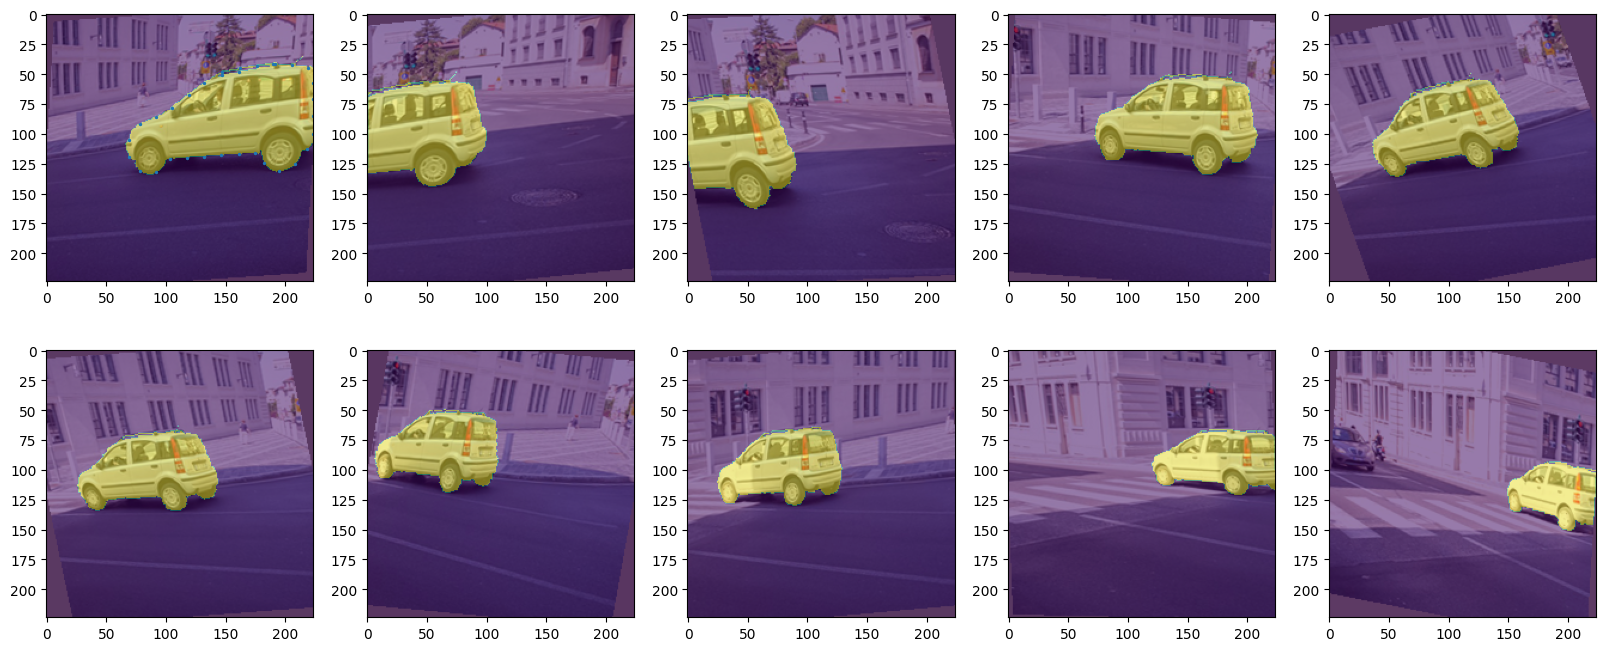

In [100]:
imgs, masks, points = val_dataset[8]
print(imgs.shape, masks.shape, points.shape)
# show all the 10 frames and the points of the first frame
# 5 images in a row
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(normalize(imgs[i].permute(1, 2, 0)))
    plt.imshow(masks[i], alpha=0.5)
    # plt.axis("off")
    if i == 0:
        plt.scatter(points[i, :, 0], points[i, :, 1], s=2)
    

In [139]:
class CoEvaler:
    def __init__(
        self,
        raw_set: list[list[tuple[torch.Tensor, torch.Tensor, torch.Tensor]]],
        gt_rasterizer: SoftPolygon,
        frame_num: int = 10,
        use_uniform_points: bool = False,
    ):
        self.raw_set = raw_set
        self.frame_num = frame_num
        self.gt_rasterizer = gt_rasterizer
        self.total_pred_results = []
        self.use_uniform_points = use_uniform_points

    def eval_one_video(self, video_idx: int, model: Cotracker):
        video_data = self.raw_set[video_idx]
        total_frame_num = len(video_data)
        img_list = []
        mask_list = []
        point_list = []
        for frame_idx in range(total_frame_num):
            img, mask, point = video_data[frame_idx]
            img_list.append(img)
            mask_list.append(mask)
            point_list.append(point)
        total_masks = torch.stack(mask_list)
        total_points = torch.stack(point_list)
        total_pred_points = torch.zeros_like(total_points)
        total_pred_points[0] = total_points[0]
        interval = (total_frame_num - 1) // (self.frame_num - 1)
        offset_min = -(interval - 1)
        offset_max = (total_frame_num - 1) - (self.frame_num - 1) * interval
        done_idx_list = [0]
        for offset in range(offset_min, offset_max + 1):
            selected_frame_idxs = [0]
            for i in range(1, self.frame_num):
                selected_frame_idxs.append(i * interval + offset)
            selected_frame_idxs = sorted(selected_frame_idxs)
            img_list = []
            mask_list = []
            point_list = []
            fir_point = video_data[0][2]
            if self.use_uniform_points:
                fir_point = _get_boundary_points(video_data[0][1], 32)
                if fir_point.shape[0] != 32 or len(fir_point.shape) != 2:
                    fir_point = video_data[0][2]
            for frame_idx in selected_frame_idxs:
                img, mask, point = video_data[frame_idx]
                img_list.append(img)
                mask_list.append(mask)
                point_list.append(fir_point)
            imgs = torch.stack(img_list).unsqueeze(0)
            masks = torch.stack(mask_list).unsqueeze(0)
            points = torch.stack(point_list).unsqueeze(0)
            with torch.no_grad():
                model.eval()
                pred_points = model(imgs.cuda(), points.cuda())
                pred_points = pred_points.clamp(0, 223)
            pred_points = pred_points[0][-1]
            for result_idx, frame_idx in enumerate(selected_frame_idxs[1:]):
                if frame_idx in done_idx_list:
                    continue
                done_idx_list.append(frame_idx)
                total_pred_points[frame_idx] = pred_points[result_idx]
        total_iou = get_batch_average_bou_iou(
            total_pred_points.cuda(),
            total_masks.cuda(),
            self.gt_rasterizer,
        )
        return total_iou, total_pred_points

    def compute_avg_iou(self):
        iou_list = [iou for iou, _ in self.total_pred_results]
        return sum(iou_list) / len(iou_list)

    def eval_all_video(self, model: Cotracker, use_tqdm=False):
        self.total_pred_results = []
        video_num = len(self.raw_set)
        if use_tqdm:
            video_idx_list = tqdm(range(video_num))
        else:
            video_idx_list = range(video_num)
        for video_idx in video_idx_list:
            iou, pred_points = self.eval_one_video(video_idx, model)
            self.total_pred_results.append((iou, pred_points))
        return self.compute_avg_iou()

    def show_iou_distribution(self):
        iou_list = [iou.item() for iou, _ in self.total_pred_results]
        plt.hist(iou_list, bins=20)
        plt.show()

    def show_video_result(
        self,
        video_idx: int,
        gt_rasterizer: SoftPolygon,
        img_per_line=5,
        mask_alpha=0.2,
    ):
        video_data = self.raw_set[video_idx]
        frame_num = len(video_data)
        line_num = (frame_num - 1) // img_per_line + 1
        total_pred_points = self.total_pred_results[video_idx][1]
        plt.figure(figsize=(img_per_line * 4, line_num * 4))
        for i, pred_point in enumerate(total_pred_points):
            plt.subplot(line_num, img_per_line, i + 1)
            plt.axis("off")
            img, mask, point = video_data[i]
            plt.imshow(normalize(img).permute(1, 2, 0))
            iou = get_batch_average_bou_iou(
                pred_point.unsqueeze(0).cuda(), mask.unsqueeze(0).cuda(), gt_rasterizer
            ).item()
            plt.title(f"IoU: {iou:.4f}")
            plt.scatter(pred_point[:, 0], pred_point[:, 1], c="r", s=5)
            plt.plot(pred_point[:, 0], pred_point[:, 1], c="r")
            plt.imshow(mask, alpha=mask_alpha)


In [108]:
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()

In [140]:
coevaler = CoEvaler(val_point_set.raw_data_set, gt_rasterizer, use_uniform_points=True)

In [104]:
model = Cotracker(32).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [106]:
model_path = "model/cotracker_you_best.pth"
model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_3453031/2802424180.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [145]:
coevaler.eval_one_video(4, model)

(tensor(0.2189, device='cuda:0'),
 tensor([[[126.8370, 114.3775],
          [126.4935, 126.6861],
          [121.9390, 136.9449],
          ...,
          [131.6513, 125.3525],
          [130.3480, 110.7069],
          [120.4019, 104.4601]],
 
         [[127.9314, 103.6871],
          [122.9877, 103.2531],
          [118.2772, 106.0785],
          ...,
          [137.6692, 118.2713],
          [130.7760, 114.9188],
          [131.5131, 102.2980]],
 
         [[123.3278,  99.4538],
          [118.6189,  96.3521],
          [115.2926,  97.8200],
          ...,
          [130.9869, 113.7690],
          [128.3130, 107.7921],
          [125.8410, 100.0925]],
 
         ...,
 
         [[ 83.2032, 117.8600],
          [ 82.2161, 110.8562],
          [ 80.0169, 106.8354],
          ...,
          [ 86.3657, 123.4963],
          [ 85.6171, 120.8760],
          [ 84.9649, 120.3852]],
 
         [[ 84.0907, 116.7668],
          [ 83.5544, 112.1904],
          [ 80.9608, 104.7832],
          ...,

In [146]:
coevaler.eval_all_video(model, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [03:33<00:00,  3.74s/it]


tensor(0.4213, device='cuda:0')

In [57]:
len(val_dataset)

57

In [62]:
for i, (imgs, masks, points) in enumerate(val_dataset):
    print(i, imgs.shape, masks.shape, points.shape)

0 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
1 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
2 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
3 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
4 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
5 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
6 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
7 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
8 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
9 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
10 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
11 torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 32, 2])
12

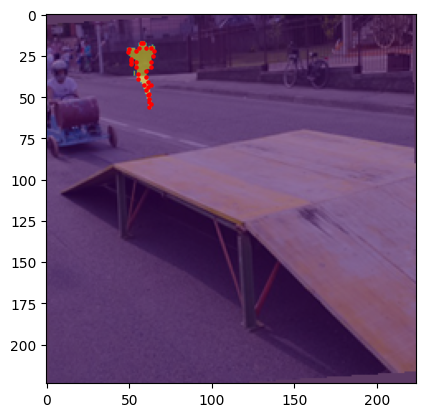

In [67]:
plt.imshow(normalize(imgs[0]).permute(1, 2, 0))
plt.imshow(masks[0], alpha=0.5)
plt.scatter(points[0][:, 0], points[0][:, 1], c="r", s=5)
plt.show()

In [ ]:
train_dataset = DAVIS_Aug_Dataset(train_raw_set.data_set, 32, 10, False)

In [ ]:
for i, (imgs, masks, points) in enumerate(train_dataset):
    print(i, imgs.shape, masks.shape, points.shape)